<h2> Importing required libraries </h2>

In [1]:
import gdown
import tarfile
import os
import pickle
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from PIL import Image  
import tensorflow as tf
from keras.regularizers import l2
import cv2 as cv
from keras.models import load_model
from tensorflow.keras.applications import DenseNet121
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.backend import expand_dims
from tensorflow import concat
tf.compat.v1.enable_eager_execution()
from tensorflow.keras.layers import TimeDistributed
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.layers import Input, Softmax, RNN, Dense, Embedding, LSTM,Layer,Dropout,GRU
from tensorflow.keras.models import Model
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import repeat
from sklearn.utils import shuffle
import nltk.translate.bleu_score as bleu
import warnings
warnings.filterwarnings('ignore')



In [2]:
url = 'https://drive.google.com/uc?id=1U7D9lnjH-0CaXzhmua2rMtmdgS4DEH2k'
output = 'proccessed.pkl'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1U7D9lnjH-0CaXzhmua2rMtmdgS4DEH2k
To: /content/proccessed.pkl
58.1MB [00:00, 130MB/s]


'proccessed.pkl'

In [3]:
url = 'https://drive.google.com/uc?id=1--clwDc2F3_CF6O4EB_BnDewFjHmFL_7'
output = 'NLMCXR_png.tgz'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1--clwDc2F3_CF6O4EB_BnDewFjHmFL_7
To: /content/NLMCXR_png.tgz
1.36GB [00:11, 120MB/s]


'NLMCXR_png.tgz'

In [4]:
cwd = os.getcwd()
tf1 = tarfile.open('NLMCXR_png.tgz')
tf1.extractall(cwd+'/png/')

In [5]:
data = pd.read_pickle('/content/proccessed.pkl')

<h2> Test train split </h2>

In [6]:
X_train, X_test = train_test_split(data.values , test_size = 0.2 )

In [7]:
X_train.shape

(2669, 8)

In [8]:
X_train = X_train[:-19, :]
X_test = X_test[:-18, :]

In [9]:
X_train.shape

(2650, 8)

In [10]:
data.columns

Index(['patient_id', 'image1', 'image2', 'findings', 'image_features',
       'findings_total', 'dec_ip', 'dec_op'],
      dtype='object')

In [11]:

t1 = Tokenizer( filters='!"#$%&()*+,-/:;=?@[\\]^_`{|}~\t\n',oov_token='OOV')
t1.fit_on_texts(X_train[:,5])
vocab_size_imp = len(t1.word_index) + 1

dec_inp = t1.texts_to_sequences(X_train[:,6])

dec_inp = pad_sequences(dec_inp, maxlen=76, padding='post') 

dec_inp_cv = t1.texts_to_sequences(X_test[:,6])

dec_inp_cv = pad_sequences(dec_inp_cv, maxlen=76, padding='post') 
 
dec_op = t1.texts_to_sequences(X_train[:,7])

dec_op = pad_sequences(dec_op, maxlen=76, padding='post') 

dec_op_cv = t1.texts_to_sequences(X_test[:,7])

dec_op_cv = pad_sequences(dec_op_cv, maxlen=76, padding='post') 

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
with open('t1.pickle', 'wb') as handle:
    pickle.dump(t1, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [82]:
!cp -r /content/t1.pickle /content/drive/MyDrive

In [16]:
vocab_size_imp

1837

In [17]:
imp1 = {}
imp2 = {}
for key,value in t1.word_index.items():
  imp1[value] = key
  imp2[key] = value

<h2> Encoder </h2>

In [48]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,units):
        super().__init__()
        self.units = units
        self.dense = Dense(self.units,name = 'Enc_dense')
        

    def call(self,img):
      '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- All encoder_outputs, last time steps hidden and cell state
      '''
      #enc_out = self.maxpool(tf.expand_dims(img,axis = 2))
      enc_out = self.dense(img)
      return enc_out

    
    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      '''
      self.batch_size  = batch_size
      
      self.enc_h =tf.zeros((self.batch_size, self.units))
      
      #self.enc_c = tf.zeros((self.batch_size, self.lstm_size))
      return self.enc_h


<h2> Attention </h2>

In [49]:
class Attention(tf.keras.layers.Layer):
  '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,att_units):
    # Please go through the reference notebook and research paper to complete the scoring functions
    super().__init__()
    
    self.att_units = att_units  

    self.w1 =  tf.keras.layers.Dense( self.att_units , name = 'w1')
    self.w2 =  tf.keras.layers.Dense( self.att_units,name = 'w2')
    self.v =  tf.keras.layers.Dense(1,name = 'v')
  
  def call(self,decoder_hidden_state,encoder_output):
    '''
      Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
      * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
        Multiply the score function with your encoder_outputs to get the context vector.
        Function returns context vector and attention weights(softmax - scores)
    '''
    self.decoder_hidden_state = decoder_hidden_state
    self.encoder_output = encoder_output

       
    self.decoder_hidden_state = tf.expand_dims(self.decoder_hidden_state,axis = 1)
    score = self.v(tf.nn.tanh(
              self.w1(self.decoder_hidden_state) + self.w2(self.encoder_output)))
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * self.encoder_output
    context_vector = tf.reduce_sum(context_vector, axis=1)   
    return context_vector,attention_weights
    
    
    

<h2> Onestepdecoder </h2>

In [50]:
class OneStepDecoder(tf.keras.Model):
  def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units  ,att_units):

      # Initialize decoder embedding layer, LSTM and any other objects needed
      super().__init__()
      self.tar_vocab_size = tar_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length
      self.dec_units = dec_units
      self.att_units = att_units
      self.dec_emb = Embedding(tar_vocab_size,embedding_dim,trainable = True , name = 'dec_embb')           
      self.dec_lstm = GRU(self.dec_units, return_state=True, return_sequences=True, name="Decoder_LSTM") 
      self.dense   = Dense(self.tar_vocab_size, name = 'one_dec')
      self.attention=Attention( self.att_units)
      self.d1 = Dropout(0.3,name = 'd1')
      self.d2 = Dropout(0.3,name = 'd2')
      self.d3 = Dropout(0.3,name = 'd3')

  @tf.function
  def call(self,input_to_decoder, encoder_output, state_h):
    '''
        One step decoder mechanisim step by step:
      A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step -B
    '''
    self.input_to_decoder = input_to_decoder
    self.encoder_output = encoder_output
    self.state_h = state_h
    
    #A
    target_embedd           = self.dec_emb (self.input_to_decoder)     #(batch_size,1,embedingdim)
    #B
    target_embedd = self.d1(target_embedd)
    
    context_vector,attention_weights=self.attention(self.state_h,self.encoder_output) #context vector shape = (batch_size,att_units)
    #C
    concated = tf.concat([  tf.expand_dims(context_vector, 1),target_embedd], -1)
    concated = self.d2(concated)

    #D
    lstm_output, hs      = self.dec_lstm(concated, initial_state=self.state_h)

    lstm_output = tf.reshape(lstm_output, (-1, lstm_output.shape[2]))
    lstm_output = self.d3(lstm_output)
    #E
    op = self.dense(lstm_output)
    #op = tf.squeeze(op,[1])
    return op,hs,attention_weights,context_vector



<h2> Decoder </h2>

In [51]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,att_units):
      #Intialize necessary variables and create an object from the class onestepdecoder
      super().__init__()
      self.out_vocab_size = out_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length
      self.dec_units = dec_units
      self.att_units = att_units
      self.onestep = OneStepDecoder(self.out_vocab_size,self.embedding_dim ,self.input_length,self.dec_units,self.att_units)

    @tf.function
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state):
      

        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook
        
        #Iterate till the length of the decoder input
            # Call onestepdecoder for each token in decoder_input
            # Store the output in tensorarray
        # Return the tensor array

        all_outputs = tf.TensorArray(tf.float32,size =input_to_decoder.shape[1],name = 'output_arrays' )
        self.input_to_decoder = input_to_decoder
        self.encoder_output = encoder_output
        self.decoder_hidden_state = decoder_hidden_state
        
        for timestep in tf.range(input_to_decoder.shape[1]):
          op,hs,attention_weights,context_vector = self.onestep(self.input_to_decoder[:,timestep:timestep+1], self.encoder_output, self.decoder_hidden_state)
          self.decoder_hidden_state = hs
          all_outputs = all_outputs.write(timestep,op)
        all_outputs = tf.transpose(all_outputs.stack(),[1,0,2])
        return all_outputs

<h2> Encoder - Decoder </h2>

In [53]:
class encoder_decoder(tf.keras.Model):
  #def __init__(self,#params):
    #Intialize objects from encoder decoder
  def __init__(self,out_vocab_size , embedding_size_d, input_length_d,lstm_size_d,att_units,batch_size,units):
        
        #Create encoder object
        #Create decoder object
        #Intialize Dense layer(out_vocab_size) with activation='softmax'
        super().__init__()

        self.units = units
        self.out_vocab_size = out_vocab_size
        self.embedding_size_d = embedding_size_d
        self.lstm_size_d = lstm_size_d
        self.input_length_d = input_length_d
        self.batch_size = batch_size
        self.att_units = att_units
        
        self.encoder = Encoder(self.units)
        
        self.decoder = Decoder(out_vocab_size , embedding_size_d, input_length_d,lstm_size_d,att_units )
        #self.dense   = TimeDistributed(Dense(self.out_vocab_size, activation='softmax'))
        self.dense   = Dense(self.out_vocab_size,name = 'enc_dec_dense')


  
  def call(self,data):
    #Intialize encoder states, Pass the encoder_sequence to the embedding layer
    # Decoder initial states are encoder final states, Initialize it accordingly
    # Pass the decoder sequence,encoder_output,decoder states to Decoder
    # return the decoder output
    self.inputs,self.outputs = data[0], data[1]
    print("="*20, "ENCODER", "="*20)
    self.encoder_h= self.encoder.initialize_states(self.batch_size)
    self.encoder_output = self.encoder(self.inputs)
    print("-"*27)
    print("ENCODER ==> OUTPUT SHAPE",self.encoder_output.shape)
    print("ENCODER ==> HIDDEN STATE SHAPE",self.encoder_h.shape)
    print("="*20, "DECODER", "="*20)
    output= self.decoder(self.outputs,self.encoder_output,self.encoder_h)
    print("-"*27)
    print("FINAL OUTPUT SHAPE",output.shape)
    print("="*50)
    return output





<h2> Loss function </h2>

In [54]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)
  #out_vocab_size , embedding_size_d, input_length_d,lstm_size_d,att_units,batch_size)

<h2> Call Backs <h2>

In [55]:
!mkdir checkpoint

mkdir: cannot create directory ‘checkpoint’: File exists


In [56]:
checkpoint_filepath = cwd + '/' + 'checkpoint' + '/'

In [26]:
checkpoint_filepath

'/content/checkpoint/'

<h3> Check point <h3>

In [57]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    verbose = 1,
    mode='min',
    save_best_only=True)

In [58]:
tf.keras.backend.clear_session()

<h3> LR optimizer <h3>

In [59]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,mode = 'min',verbose = 1,
                              patience=2, min_lr=0.0001)

<h2> Compiling model </h2>

In [60]:
model_1 = encoder_decoder(vocab_size_imp,300,76,256,64,50,256)
optimizer = tf.keras.optimizers.Adam()
model_1.compile(optimizer=optimizer,loss=loss_function)

In [61]:
train_inp = np.vstack(X_train[:,4]).astype(np.float)
test_inp = np.vstack(X_test[:,4]).astype(np.float)

<h2> fitting model </h2>

In [62]:
model_1.fit([train_inp,dec_inp ],dec_op ,validation_data= ([test_inp, dec_inp_cv],dec_op_cv),batch_size= 50,epochs  = 40,callbacks=[reduce_lr,model_checkpoint_callback] , shuffle=True)

Epoch 1/40
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (50, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (50, 76, 1837)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (50, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (50, 76, 1837)
53/53 [==============================] - ETA: 0s - loss: 2.4360==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (50, 256)
ENCODER ==> HIDDEN STATE SHAPE (50, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (50, 76, 1837)
53/53 [==============================] - 17s 285ms/step - loss: 2.4327 - val_loss: 2.1810

Epoch 00001: val_loss improved from i

<h2> Inferring Using Beam Search </h2>

In [ ]:
model_1.load_weights(checkpoint_filepath)

In [63]:
#https://machinelearningmastery.com/beam-search-decoder-natural-language-processing/
#https://github.com/vysakh10/Medical-Report-Generation-using-Deep-Learning/blob/master/Attention_Onestep_Mod.ipynb
def beam(sentence):
  """ Thi function predicts the sentence using beam search """

  initial_state=model_1.layers[0].initialize_states(1)
  encoder_output= model_1.layers[0](sentence)
  result = ''

  sequences = [['<start>' ,initial_state, 0]]

  decoder_hidden_state = initial_state

  #cur_vec = np.ones((1, 1)) * imp2['<start>'] 
  #cur_vec = np.array([[1]])
  finished_seq = []
  beam_width = 3

  for i in range(76):
    all_candidates = []
    new_seq = []
    for s in sequences:

      cur_vec = np.reshape(imp2[s[0].split(" ")[-1]],(1,1))
      decoder_hidden_state = s[1]
      op,hs,attention_weights,context_vector = model_1.layers[1].onestep(cur_vec, encoder_output, decoder_hidden_state)
      op = tf.nn.softmax(op)
      top3 = np.argsort(op).flatten()[-beam_width:]
      for t in top3:
         
         candidates = [s[0] + ' '+ imp1[t], hs,s[2]-np.log(np.array(op).flatten()[t])]
         all_candidates.append(candidates)
    sequences = sorted(all_candidates, key = lambda l: l[2])[:beam_width]

    count = 0
    for s1 in sequences:
      if s1[0].split(" ")[-1] == '<end>':


        s1[2] = s1[2]/len(s1[0])   # normalized
        finished_seq.append([s1[0], s1[1],s1[2]])
        count+=1
      else:

        new_seq.append([s1[0], s1[1],s1[2]])
   
    beam_width -= count
    sequences = new_seq
    if not sequences:
      break        
    else:
      continue

  if len(finished_seq) >0:
    sequences = finished_seq[-1] 
    return sequences[0]
  else:
    return new_seq[-1][0]

  

In [64]:
data.columns

Index(['patient_id', 'image1', 'image2', 'findings', 'image_features',
       'findings_total', 'dec_ip', 'dec_op'],
      dtype='object')

<h2> Image data for inference </h2>

Original Sentence is :  <start> there are postoperative changes of sternotomy. there is cardiomegaly. the contour of the ascending aorta is prominent, consistent with known ascending aortic aneurysm. the lungs appear clear. no focal airspace consolidation. no pleural effusion or pneumothora. there are minimal degenerative changes of the spine.
Predicted Sentence is :  <start> the heart is normal in size and contour. the lungs are clear without evidence of infiltrate. there is no pneumothora or pleural effusion. <end>


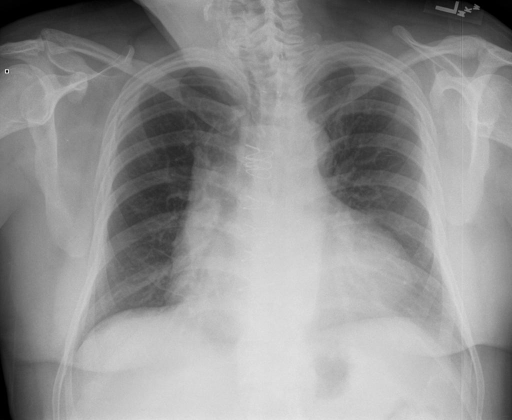

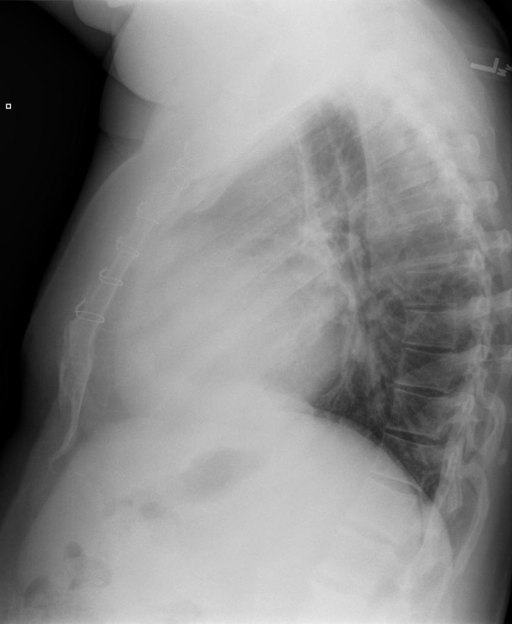

In [65]:
num = 16 #random test sample
im_o = np.vstack(X_test[:,4][num]).astype(np.float)
tex_o = X_test[:,6][num]

print("Original Sentence is : " , tex_o)
print("Predicted Sentence is : ",beam(im_o))
img = cv2.imread(X_test[:,1][num], cv2.IMREAD_UNCHANGED)
cv2_imshow(img)
img = cv2.imread(X_test[:,2][num], cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

Original Sentence is :  <start> mediastinal contours are normal. lungs are clear. there is no pneumothora or large pleural effusion.
Predicted Sentence is :  <start> the heart size is normal. the lungs are clear without infiltrate. there is no effusion or pneumothora. <end>
The X-Rays are : 


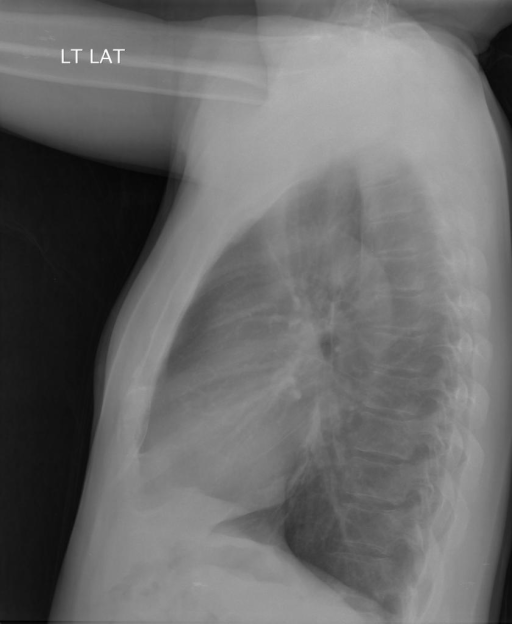

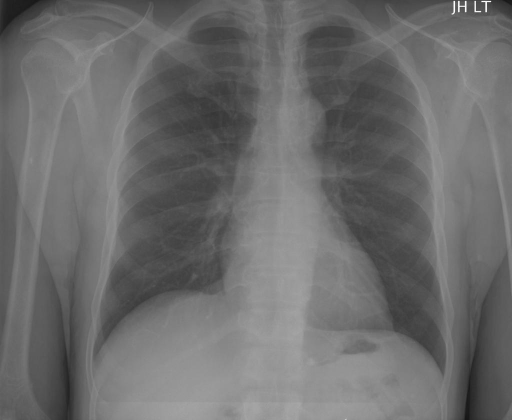

In [66]:
num =63 #random test sample
im_o = np.vstack(X_test[:,4][num]).astype(np.float)
tex_o = X_test[:,6][num]

print("Original Sentence is : " , tex_o)
print("Predicted Sentence is : ",beam(im_o))
print("The X-Rays are : ")
img = cv2.imread(X_test[:,1][num], cv2.IMREAD_UNCHANGED)
cv2_imshow(img)
img = cv2.imread(X_test[:,2][num], cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

Original Sentence is :  <start> heart size normal. stable cardiomediastinal silhouette. no pneumothora, pleural effusion, or focal airspace disease. bony structures are in alignment without fracture.
Predicted Sentence is :  <start> the heart is normal in size and mediastinal contours are within normal limits. there is no pleural effusion or pneumothora. there is no focal air space opacity to suggest a pneumonia. there is no pleural effusion or pneumothora. there is no focal air space opacity to suggest a pneumonia. there is no pleural effusion or pneumothora. there is no focal air space opacity to suggest a pneumonia. there is no pleural effusion or pneumothora. the visualized
The X-Rays are : 


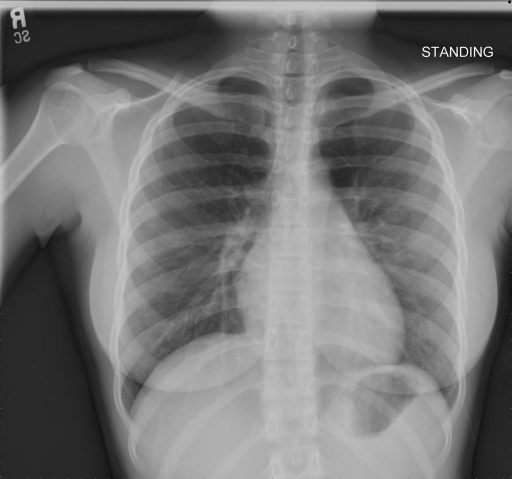

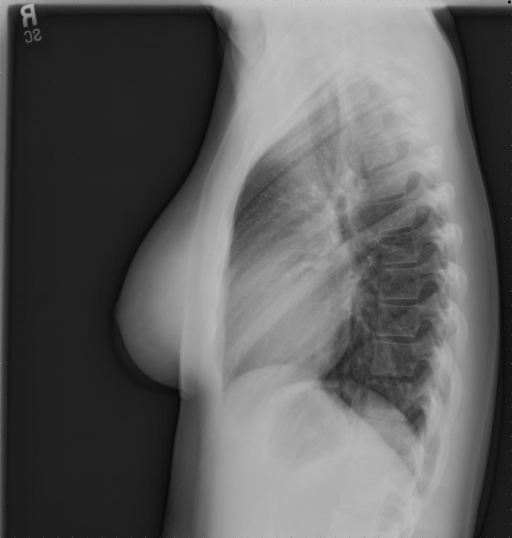

In [67]:
num = 118 #random test sample
im_o = np.vstack(X_test[:,4][num]).astype(np.float)
tex_o = X_test[:,6][num]

print("Original Sentence is : " , tex_o)
print("Predicted Sentence is : ",beam(im_o))
print("The X-Rays are : ")
img = cv2.imread(X_test[:,1][num], cv2.IMREAD_UNCHANGED)
cv2_imshow(img)
img = cv2.imread(X_test[:,2][num], cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

Original Sentence is :  <start> cardiomediastinal silhouette and pulmonary vasculature are within normal limits. lungs are clear. no pneumothora or pleural effusion. no acute osseous findings.
Predicted Sentence is :  <start> the heart and lungs have in the interval. both lungs are clear and epanded. heart and mediastinum are normal. the lungs are clear. no focal airspace disease or pleural effusion or pneumothora. the right lung is clear. <end>
The X-Rays are : 


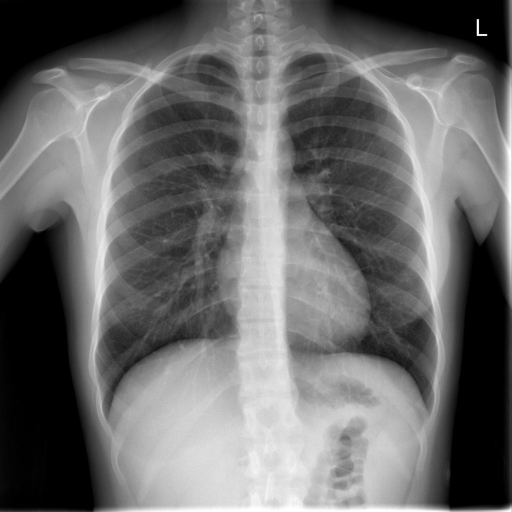

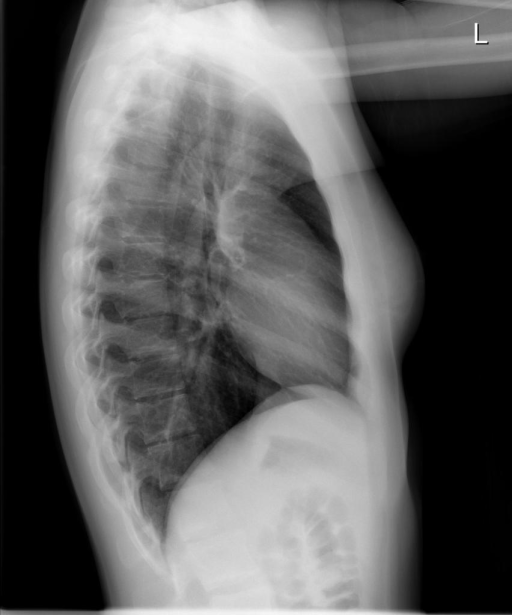

In [68]:
num = 166 #random test sample
im_o = np.vstack(X_test[:,4][num]).astype(np.float)
tex_o = X_test[:,6][num]

print("Original Sentence is : " , tex_o)
print("Predicted Sentence is : ",beam(im_o))
print("The X-Rays are : ")
img = cv2.imread(X_test[:,1][num], cv2.IMREAD_UNCHANGED)
cv2_imshow(img)
img = cv2.imread(X_test[:,2][num], cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

Original Sentence is :  <start> lungs are clear. a calcified small granuloma is present in the left lower lobe. heart size normal. mediastinum normal.
Predicted Sentence is :  <start> the cardiomediastinal silhouette is normal in size and contour. no focal consolidation pneumothora or large pleural effusion. negative for acute displaced rib fracture. <end>
The X-Rays are : 


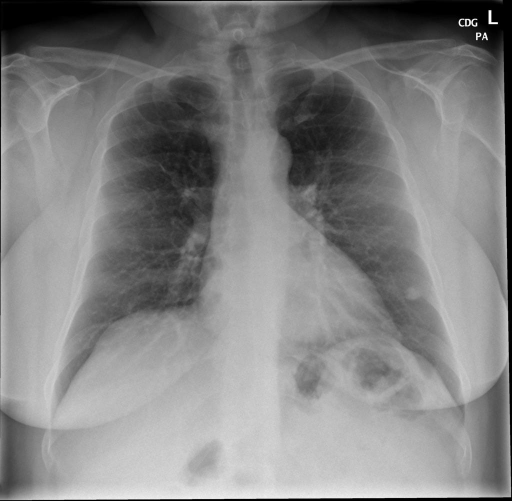

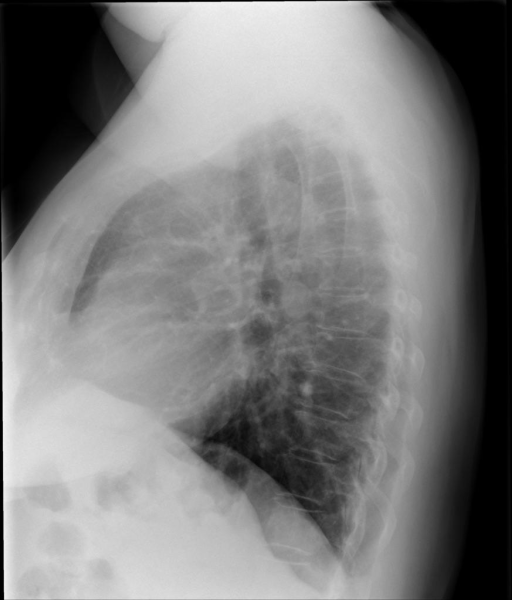

In [40]:
num = 155 #random test sample
im_o = np.vstack(X_test[:,4][num]).astype(np.float)
tex_o = X_test[:,6][num]

print("Original Sentence is : " , tex_o)
print("Predicted Sentence is : ",beam(im_o))
print("The X-Rays are : ")
img = cv2.imread(X_test[:,1][num], cv2.IMREAD_UNCHANGED)
cv2_imshow(img)
img = cv2.imread(X_test[:,2][num], cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

In [ ]:
#https://machinelearningmastery.com/calculate-bleu-score-for-text-python/
b1 = 0
b2 = 0
b3 = 0
b4 = 0


for i in range(X_test.shape[0]):
  im_o = np.vstack(X_test[:,4][i]).astype(np.float)
  pred = beam(im_o)
  org= X_test[:,5][i]

  

  
  b1 =  b1 + bleu.sentence_bleu([org.split()], pred.split() ,weights=(1, 0, 0, 0))
  b2 =  b2 + bleu.sentence_bleu([org.split()], pred.split(),weights=(0.5, 0.5, 0, 0))
  b3 =  b3 + bleu.sentence_bleu([org.split()], pred.split() ,weights=(0.33, 0.33, 0.33, 0))
  b4 =  b4 + bleu.sentence_bleu([org.split()], pred.split() ,weights=(0.25, 0.25, 0.25, 0.25))



print("Bleu1 score is : ",b1/X_test.shape[0])
print("Bleu2 score is : ",b2/X_test.shape[0])
print("Bleu3 score is : ",b3/X_test.shape[0])
print("Bleu4 score is : ",b4/X_test.shape[0])


Bleu1 score is :  0.3009085982210082
Bleu2 score is :  0.20936423249379965
Bleu3 score is :  0.20800217833881662
Bleu4 score is :  0.2420798273745578


In [78]:
model_1.save_weights("attention_modelv8.h5")

In [83]:
!cp -r /content/attention_modelv8.h5 /content/drive/MyDrive

<h2> Model Comparision <h2> 


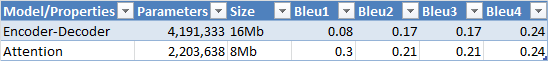